In [1]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2DTranspose, Conv2D, Concatenate, Activation, MaxPool2D, Dropout
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import clear_output
from tensorflow.keras.models import load_model

In [2]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32)/255.0
  return input_image, input_mask

In [3]:
image = []
image_path = 'brain_mri_segmentation/images'
image_files = [f for f in sorted(os.listdir(image_path))]
for image_file in tqdm(image_files):
    file_path = os.path.join(image_path, image_file)
    img = Image.open(file_path).convert('RGB').resize((256,256))
    img = np.array(img)
    image.append(img)
image = np.array(image)
image.shape

100%|██████████| 4293/4293 [00:33<00:00, 127.12it/s]


(4293, 256, 256, 3)

In [4]:
mask = []
mask_path = 'brain_mri_segmentation/masks'
mask_files = [f for f in sorted(os.listdir(mask_path))]
for mask_file in tqdm(mask_files):
    file_path = os.path.join(mask_path, mask_file)
    img = Image.open(file_path).resize((256,256))
    img = np.array(img)
    mask.append(img)
mask = np.array(mask)
mask = np.expand_dims(mask, -1)
mask.shape

100%|██████████| 4293/4293 [00:10<00:00, 404.48it/s]


(4293, 256, 256, 1)

In [5]:
image_train, image_test, mask_train, mask_test = train_test_split(image, mask, test_size=0.1, random_state=43)
image_train, image_valid, mask_train, mask_valid = train_test_split(image_train, mask_train, test_size=0.2, random_state=43)

In [6]:
dataset_train = tf.data.Dataset.from_tensor_slices((image_train, mask_train))
dataset_val = tf.data.Dataset.from_tensor_slices((image_valid, mask_valid))
dataset_test = tf.data.Dataset.from_tensor_slices((image_test, mask_test))

In [7]:
dataset_train = dataset_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
dataset_val = dataset_val.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
def augment(images, labels):
    combined = tf.concat([images, labels], axis=-1)
    
    combined = tf.image.random_flip_left_right(combined)
    
    images = combined[..., :-1]  
    labels = combined[..., -1:]  
    
    labels = tf.ensure_shape(labels, [None, 256, 256, 1])     
    return images, labels

In [9]:
train_batches = (dataset_train
           .shuffle(buffer_size=10000)  
           .batch(16)
           .prefetch(tf.data.AUTOTUNE)
           .repeat(5)
           .map(lambda x, y: augment(x, y))
)
val_batches = dataset_val.batch(16)
test_batches = dataset_test.batch(16)

In [10]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Activation("relu")(x)

    return x

In [11]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [12]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [13]:
def dice_loss(y_true, y_pred, smooth=1e-5):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1.0 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [14]:
def unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    skip_1, x = encoder_block(inputs, 64)
    skip_2, x = encoder_block(x, 128)
    skip_3, x = encoder_block(x, 256)
    skip_4, x = encoder_block(x, 512)

    x = conv_block(x, 1024)

    x = decoder_block(x, skip_4, 512)
    x = decoder_block(x, skip_3, 256)
    x = decoder_block(x, skip_2, 128)
    x = decoder_block(x, skip_1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model


In [15]:
model = unet((256,256,3))
model.summary()
model.compile(optimizer='adam', loss = dice_loss, metrics = ['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ dropout[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ dropout_1[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ dropout_2[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [23]:
model.fit(train_batches, epochs=20,validation_data = val_batches)

Epoch 1/10


I0000 00:00:1732703704.211959      77 service.cc:145] XLA service 0x7eb290003ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732703704.212029      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732703740.083389      77 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_22', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1732703740.104192      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


970/970 ━━━━━━━━━━━━━━━━━━━━ 428s 393ms/step - accuracy: 0.9955 - loss: 0.1411 - val_accuracy: 0.9932 - val_loss: 0.3039
Epoch 2/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 367s 377ms/step - accuracy: 0.9955 - loss: 0.1397 - val_accuracy: 0.9945 - val_loss: 0.2087
Epoch 3/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 367s 377ms/step - accuracy: 0.9959 - loss: 0.1207 - val_accuracy: 0.9944 - val_loss: 0.2055
Epoch 4/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 367s 377ms/step - accuracy: 0.9961 - loss: 0.1125 - val_accuracy: 0.9945 - val_loss: 0.2050
Epoch 5/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 368s 378ms/step - accuracy: 0.9963 - loss: 0.1047 - val_accuracy: 0.9943 - val_loss: 0.2105
Epoch 6/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 367s 377ms/step - accuracy: 0.9963 - loss: 0.1034 - val_accuracy: 0.9946 - val_loss: 0.1961
Epoch 7/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 367s 377ms/step - accuracy: 0.9964 - loss: 0.0980 - val_accuracy: 0.9948 - val_loss: 0.1818
Epoch 8/10
970/970 ━━━━━━━━━━━━━━━━━━━━ 367s 377ms/step - accuracy: 0.9967 - loss: 0.08

In [24]:
model.evaluate(test_batches)

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 495ms/step - accuracy: 0.9942 - loss: 0.1874


[0.17688927054405212, 0.9946678280830383]

In [54]:
model.save('unet-model.h5')

In [26]:
predictions = model.predict(test_batches)

In [27]:
predictions = np.where(predictions>0.5, 1, 0)

In [52]:
plt.imshow(image_test[6])

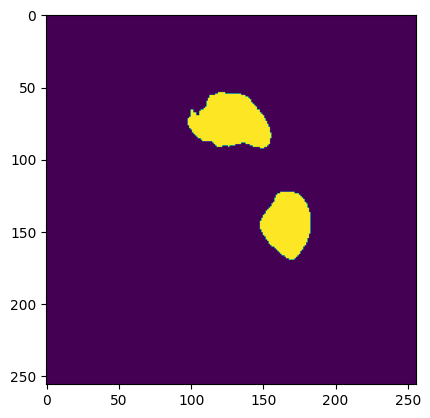

In [53]:
plt.imshow(predictions[6])

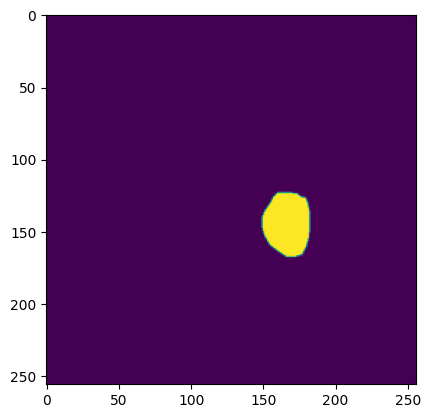

In [51]:
plt.imshow(mask_test[6])